# Tensor based NNs

Let us replace scalar values with arbitrary-dimensional tensors.
We will use numpy to store the data and the gradient.

In [41]:
import math
import numpy as np
import matplotlib.pyplot as plt

### Tensor class layout

The `Tensor` class will have both data and gradient held in numpy arrays.
The dunder methods will be augmented, but the underlying principle is the same as in the `Value` class we used before.

In [91]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
from Tensor import Tensor, draw_dot

Let us test the `Tensor` class

In [44]:
a = Tensor(shape=(2, 3), label="a")
a.data = np.random.randn(2, 3)
b = Tensor(shape=(3, 4), label="b")
b.data = np.random.randn(3, 4)

c = a @ b
c._label = "c"

d = 1.0 - c - 1.0


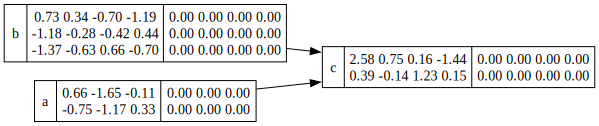

In [45]:
draw_dot(c)

Compare the much lower number of nodes using tensors as compared to scalars.  Overall, this will make our implementation more efficient.
- Individual scalar arithmetic replaced by parallelizable matrix arithmetic
- Shorter python loop
- Better data locality

An MLP can be constructed more easily now as follows.

In [46]:
class MLP:
    def __init__(self, n_in: int, n_out: int, hidden_dims: list):
        sizes = [n_in] + hidden_dims + [n_out]
        self.layers = []
        
        for i in range(len(sizes)-1):
            layer = Tensor(shape=(sizes[i+1], sizes[i]), label=f'layer {i}')
            layer.data = np.random.uniform(low=-0.05, high=0.05, size=(sizes[i+1], sizes[i]))
            self.layers.append(layer)

    def __call__(self, x):
        for idx, layer in enumerate(self.layers): 
            x = layer @ x
            if idx < len(self.layers) - 1:
                x = x.tanh()
        return x
    
    def parameters(self):
        return self.layers

We build a small MLP and visualize

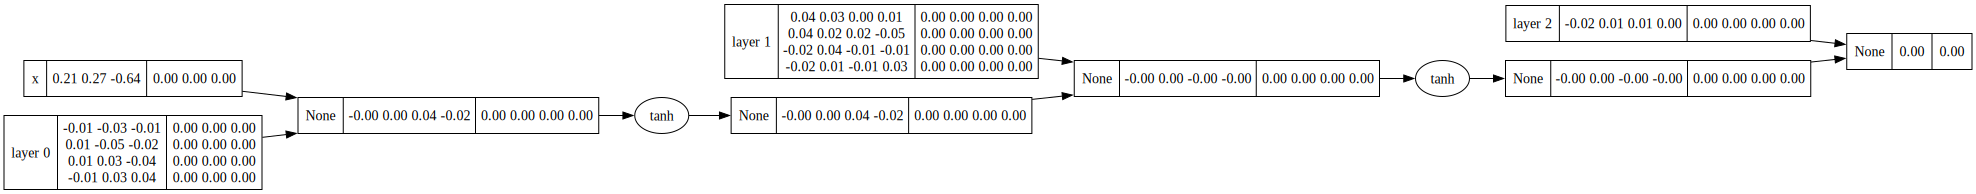

In [47]:
model = MLP(n_in=3, n_out=1, hidden_dims=[4, 4])
x = Tensor(data=np.random.randn(3,), label="x")
y = model(x)
draw_dot(y)


In [48]:
layer_1 = model.layers[0].data @ x.data
layer_1_einsum = np.einsum("ij,j->i", model.layers[0].data, x.data)
print(layer_1)
print(layer_1_einsum)

[-0.00189639  0.00085205  0.03588603 -0.02087005]
[-0.00189639  0.00085205  0.03588603 -0.02087005]


Again compare the much smaller number of nodes in the computational graph when using the Tensor class.

Let us train the MLP using the same data as for the Value-based NN.

In [49]:
data = [
    [2.0, 2.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

target = [1.0, -1.0, -1.0, 1.0] # true outputs - a binary classifier

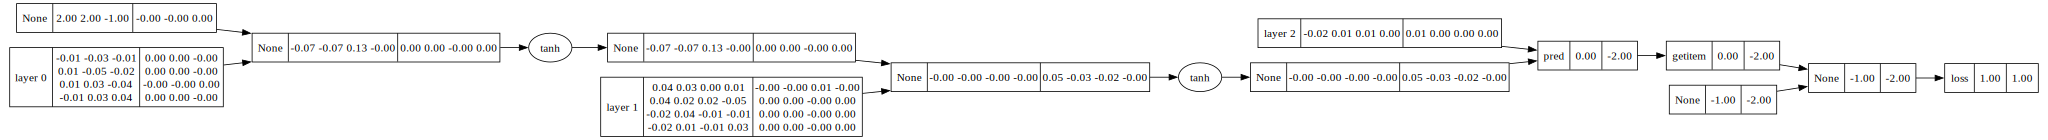

In [50]:
# Let us try computing backprop
for p in model.parameters():
        p.grad = np.zeros_like(p.grad)
pred = model(Tensor(data=data[0]))
pred._label = "pred"
loss = (pred[0] - target[0])**2
loss._label = "loss"
loss.backward()
draw_dot(loss)

The training loop becomes

In [51]:
# Training loop
losses = []
for epoch in range(1000):
    # Forward pass
    preds = [model(Tensor(data=x)) for x in data]
    
    # Loss calculation
    loss = [(ytrue - ypred)**2 for ytrue, ypred in zip(target, preds)]
    loss = sum(loss)/len(loss)
    losses.append(loss.data.item())

    # set gradients to zero
    for p in model.parameters():
        p.grad = np.zeros_like(p.grad)
    
    # backward pass
    loss.backward()
    
    # update
    learning_rate = 0.05
    for p in model.parameters():
        # The weight update
        p.data += -learning_rate * p.grad

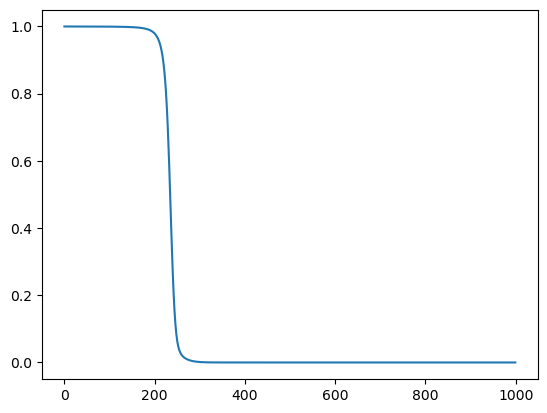

In [52]:
plt.plot(losses)

# Classification

Now we have a way to generate more efficient neural networks. Let us use that on a real task: Classifying images with the MNIST dataset.data

Until now we have only done regression. For classification, we will need a way to encode classes and a corresponding loss function.

## Softmax

In order to classify one of `K` classes, we compute a neural network with `K` output values.
Then, the one with the highest score can be chosen to be the classification prediction.
For NNs, these scores are transformed into probabilities via the soft max function.
In particular, this transformation is rank-preserving: Higher scores lead to higher probabilities.

![Softmax function](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*gctBX5YHUUpBEK3MWD6r3Q.png)


Then, the classification can either be the mode or samples according to the obtained probabilities.
Let us implement softmax.

In [53]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x))

In [54]:
a = [0.0, 1.0, 3.0]
softmax(a)

array([0.04201007, 0.1141952 , 0.84379473])

In [55]:
# will still work
a = [1.0, 10.0, 100.0]
softmax(a)

array([1.01122149e-43, 8.19401262e-40, 1.00000000e+00])

In [56]:
# will not work anymore
a = [1.0, 10.0, 100.0]
softmax(a)

array([1.01122149e-43, 8.19401262e-40, 1.00000000e+00])

### LogExpSum Trick
In order to make the softmax numerically stable, we can perform the log-sum-exp trick. Otherwise, exp can overflow very easily or the exp-sum can be so small we get numerical issues as well (see exercise).

In [57]:
def stable_softmax(x):
    z = x - np.max(x)
    return np.exp(z) / np.sum(np.exp(z))

In [58]:
a = [0.0, 1.0, 3.0]
stable_softmax(a)

array([0.04201007, 0.1141952 , 0.84379473])

In [59]:
a = [10.0, 100.0, 1000.0]
stable_softmax(a)

array([0., 0., 1.])

In [60]:
# add softmax function to Tensor class
a = Tensor(data=a)
softmax = a.softmax()
softmax

Tensor(data=[0. 0. 1.])

### Softmax Jacobian

Softmax is a vector function, i.e.

$$ \text{softmax}: \mathbb{R}^n \rightarrow \mathbb{R}^n\,. $$

Therefore, the derivative of the softmax function needs to be a matrix as well, which we call the Jacobian, containing all possible partial derivatives:

$$ 
\nabla \text{softmax} = \begin{pmatrix}
\frac{\partial s_1}{\partial z_1} & \frac{\partial s_1}{\partial z_2} & \cdots & \frac{\partial s_1}{\partial z_n} \\
\frac{\partial s_2}{\partial z_1} & \frac{\partial s_2}{\partial z_2} & \cdots & \frac{\partial s_2}{\partial z_n} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\partial s_n}{\partial z_1} & \frac{\partial s_n}{\partial z_2} & \cdots & \frac{\partial s_n}{\partial z_n}
\end{pmatrix} 
$$

where

$$ s_i = \frac{e^{z_i}}{\sum_{i=1}^n e^{x_i}} $$

Notice how each input of the softmax depends on all the input values due to the denominator.
This results in non-zero off-diagonal elements in the Jacobian (compare to matrix derivative and contrast to separable functions like elementwise addition/multiplication, activation functions, ...).

##### Log-derivative trick

Directly doing the derivative will not be pretty due to having to use the quotient rule. Instead,

$$ \frac{\partial}{\partial z_j} \log(s_i) = \frac{1}{s_i} \cdot \frac{\partial s_i}{\partial z_j} $$

which follows from the chain rule. Rearrange:

$$ \frac{\partial s_i}{\partial z_j} = s_i \cdot \frac{\partial}{\partial z_j} \log(s_i) $$

Plugging in $s_i$ gives

$$ \log(s_i) = \log(\frac{e^{z_i}}{\sum_{l=1}^n e^{z_l}}) = z_i - \log(\sum_{l=1}^n e^{z_i}) $$

The partial derivative of the resulting expression is

$$ \frac{\partial}{\partial z_j} \log(s_i) = \frac{\partial z_i}{\partial z_j} - \frac{\partial}{\partial z_j} \log(\sum_{l=1}^n e^{z_l}) $$

The first term is $\delta_{i=j}$, the second term can be computed using the chain rule:

$$ \frac{\partial}{\partial z_j} \log(s_i) = \delta_{i = j} - \frac{1}{\sum_{l=1}^n e^{z_i}} \cdot e^{z_i} $$

Rewriting yields

$$ \frac{\partial s_i}{\partial z_j} = s_i \cdot \frac{\partial}{\partial z_j} \log(s_i) = s_i \cdot (\delta_{i = j} - s_j) $$

The Jacobian now is

$$ 
\nabla \text{softmax} = \begin{pmatrix}
s_1 \cdot (1-s_1) & -s_1 \cdot s_2 & \cdots & -s_1 \cdot s_n \\
-s_2 \cdot s_1 & s_2 \cdot (1-s_2) & \cdots & -s_2 \cdot s_n \\
\vdots & \vdots & \ddots & \vdots \\
-s_n \cdot s_1 & -s_n \cdot s_2 & \cdots & s_n \cdot (1-s_n)
\end{pmatrix} 
= \text{diag}(\text{softmax}) - \text{softmax}^{\top} \cdot \text{softmax}
$$

# Cross-Entropy Loss

When we develop a model for probabilistic classification, we aim to map the model's inputs to probabilistic *predictions*, and we often *train* our model by incrementally adjusting the model's parameters so that our predictions get closer and closer to *ground-truth probabilities.*

We will focus on models that assume that classes are mutually exclusive. For example, if we're interested in determining whether an image is best described as a landscape *or* as a house *or* as something else, then our model might accept an image as input and produce three numbers as output, each representing the probability of a single class.

During training, we might put in an image of a landscape, and we hope that our model produces predictions that are close to the ground-truth class probabilities $y = (1.0, 0.0, 0.0)^T$. If our model predicts a different distribution, say $\hat{y} = (0.4, 0.1, 0.5)^T$, then we'd like to nudge the parameters so that $\hat{y}$ gets closer to $y$.

But what exactly do we mean by "gets closer to"? In particular, how should we measure the difference between $\hat{y}$ and $y$?

We describe one possible measure, *cross entropy*, and describes why it's reasonable for the task of classification.

## Entropy

Let's say you're standing next to a highway in Boston during rush hour, watching cars inch by, and you'd like to communicate each car model you see to a friend. You're stuck with a binary channel through which you can send *0* or *1*, and it's expensive: you're charged `$0.10` per bit.

You need many bit sequences, one for each car model.

How would you allocate bit sequences to the car models? Would you use the same number of bits for the Toyota Camry sequence as you would for the Tesla Model S sequence?

No, you wouldn't. You'd allocate less bits to the Camry, because you know that you'll end up sending the Camry sequence much more often than the Tesla Model S sequence. What you're doing is exploiting your knowledge about the distribution over car models to reduce the number of bits that you need to send on average.

It turns out that if you have access to the underlying distribution $y$, then to use the smallest number of bits on average, you should assign $\log \frac{1}{y_i}$ bits to the $i$-th symbol. (As a reminder, $y_i$ is the probability of the $i$-th symbol.)

For example, if we assume that seeing a Toyota is 128x as likely as seeing a Tesla, then we'd give the Toyota symbol 7 less bits than the Tesla symbol:

$$ b_{toyota}
= \log \frac{1}{128 p_{tesla}}
= \log \frac{1}{p_{tesla}} + \log \frac{1}{128}
= b_{tesla} - 7 $$

By fully exploiting the known distribution $y$ in this way, we achieve an optimal number of bits per transmission. The optimal number of bits is known as [entropy](https://en.wikipedia.org/wiki/Entropy_%28information_theory%29). Mathematically, it's just the expected number of bits under this optimal encoding:

$$ H(y) = \sum_i y_i \log \frac{1}{y_i} = -\sum_i y_i \log y_i $$

## Cross Entropy

If we think of a distribution as the tool we use to encode symbols, then entropy measures the number of bits we'll need if we use the *correct* tool $y$. This is optimal, in that we can't encode the symbols using fewer bits on average.

In contrast, [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy) is the number of bits we'll need if we encode symbols from $y$ using the *wrong* tool $\hat{y}$. This consists of encoding the $i$-th symbol using $\log \frac{1}{\hat{y}_i}$ bits instead of $\log \frac{1}{y_i}$ bits. We of course still take the expected value to the true distribution $y$, since it's the distribution that truly generates the symbols:

$$ H(y, \hat{y}) = \sum_i y_i \log \frac{1}{\hat{y}_i} = -\sum_i y_i \log \hat{y}_i $$

Cross entropy is always larger than entropy; encoding symbols according to the wrong distribution $\hat{y}$ will always make us use more bits. The only exception is the trivial case where $y$ and $\hat{y}$ are equal, and in this case entropy and cross entropy are equal.

## KL Divergence

The [KL divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) from $\hat{y}$ to $y$ is simply the *difference* between cross entropy and entropy:

$$ \text{KL}(y~||~\hat{y})
= \sum_i y_i \log \frac{1}{\hat{y}_i} - \sum_i y_i \log \frac{1}{y_i}
= \sum_i y_i \log \frac{y_i}{\hat{y}_i} $$

It measures the number of *extra* bits we'll need on average if we encode symbols from $y$ according to $\hat{y}$; you can think of it as a bit tax for encoding symbols from $y$ with an inappropriate distribution $\hat{y}$. It's never negative, and it's 0 only when $y$ and $\hat{y}$ are the same.

Note that minimizing cross entropy is the same as minimizing the KL divergence from $\hat{y}$ to $y$. (They're equivalent up to an additive constant, the entropy of $y$, which doesn't depend on $\hat{y}$.)

Let us visualize the binary cross entropy:

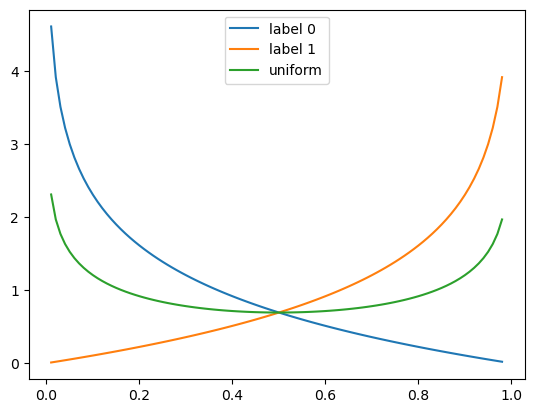

In [61]:
x = np.arange(0.01, 0.99, 0.01)
y = [1.0, 0.0] # label 0
cs_0 = - 1.0 * np.log(x) - 0.0 * np.log(1 - x)
y = [0.0, 1.0] # label 1
cs_1 = - 0.0 * np.log(x) - 1.0 * np.log(1 - x)
y = [0.5, 0.5] # label 0.5
cs_05 = - 0.5 * np.log(x) - 0.5 * np.log(1 - x)

plt.plot(x, cs_0, label="label 0")
plt.plot(x, cs_1, label="label 1")
plt.plot(x, cs_05, label="uniform")
# Add legend
plt.legend()

Let us implement the cross-entropy loss.

In [62]:
def cross_entropy(self, target):
    cs = -np.sum(target * np.log(self), axis=-1, keepdims=False)

    def _backward(self, target, out):
        self.grad += -target / self * out.grad

    return cs

In [63]:
# and test it
a = [0.1, 0.6, 0.3]
b = [0.7, 0.2, 0.1]
cs_ab = cross_entropy(a,b)
cs_aa = cross_entropy(a,a)
cs_bb = cross_entropy(b,b)
print(cs_ab)
print(cs_aa)
print(cs_bb)

1.8343719702816235
0.8979457248567798
0.8018185525433372


# Classification with MNIST

Next, we will train a somewhat larger neural network to classify MNIST images. We will use cross-entropy on softmax outputs to that end.

In [108]:
# Alternative: MNIST
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False, cache=True)
X, y = mnist['data'], mnist['target']
y = y.astype(int)

# Generate train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(52500, 784) (17500, 784) (52500,) (17500,)


In [67]:
X_train.shape

(52500, 784)

In [68]:
X_test.shape

(17500, 784)

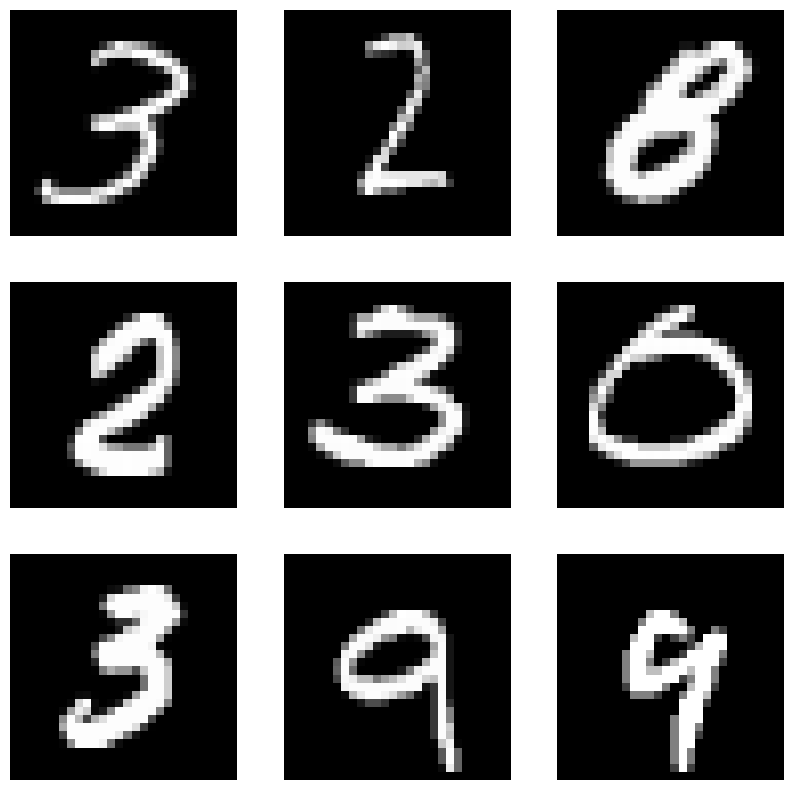

In [69]:
# Visualize the first 9 digites
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for i in range(9):
    ax = axs[i//3, i%3]
    ax.imshow(X_train[i].reshape(28, 28), cmap='gray')
    ax.axis('off')


In [109]:
# Normalize the input data:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('int64')
y_test = y_test.astype('int64')
X_train /= 255.0
X_test /= 255.0

## Classifier Network
Now we will build an MLP for classifying MNIST images.
For our MLP we will have 10 output values on which we will apply softmax.

In [71]:
class MNIST_Net:
    def __init__(self):
        self.mlp = MLP(n_in=784, n_out=10, hidden_dims=[64])
    def __call__(self, x):
        return self.mlp(x).softmax()
    def parameters(self):
        return self.mlp.parameters()
    
model = MNIST_Net()

In [72]:
# Test the model
print(model(X_train[0]))
print(model(X_train[0]).cross_entropy(y_train[0]))

Tensor(data=[0.09968059 0.0983661  0.09736371 0.09614686 0.09529095 0.1050817
 0.10199986 0.10410228 0.09560819 0.10635976])
Tensor(data=2.3418785063641003)


In [73]:
# Training loop
losses = []
# for epoch in range(10):
#     # Forward pass
#     preds = [model(x) for x in X_train]
    
#     # Loss calculation
#     loss = [ypred.cross_entropy(ytrue) for ytrue, ypred in zip(y_train, preds)]
#     loss = sum(loss)/len(loss)
#     losses.append(loss.data)
    
#     ### ZERO GRAD ###
#     for p in model.parameters():
#         p.grad = 0.0
        
#     # backward pass
#     loss.backward()
    
#     # update
#     learning_rate = 0.005
#     for p in model.parameters():
#         # The weight update
#         p.data += -learning_rate * p.grad

Gradient descent does not work on MNIST anymore.
The problem is that our computational graph is too deep and we reach the recursion limit in python.
For even larger problem datasets we would not even be able to store all the activations in memory.
For this reason, stocahstic gradient descent is used in practice.

## Stochastic Gradient Descent

Recall Gradient Descent:

$$
\begin{array}{l}
\textbf{Algorithm: Stochastic Gradient Descent} \\
\text{for each epoch } e = 1 \text{ to } E \text{ do} \\
\quad D = 0 \\
\quad \text{for each data point } \{(x_i, y_i)\} \text{ do} \\
\quad \quad \text{Update the gradient } D = D + \frac{1}{n} \nabla_\theta L(\theta; x_i, y_i) \\
\quad \text{end for} \\
\quad \text{Update the parameters: } \theta \gets \theta - \eta D \\
\text{end for}
\end{array}
$$

SGD is working as follows:

$$
\begin{array}{l}
\textbf{Algorithm: Stochastic Gradient Descent} \\
\text{for each epoch } e = 1 \text{ to } E \text{ do} \\
\quad \text{for each data point } \{(x_i, y_i)\} \text{ do} \\
\quad \quad \text{Compute the gradient } \nabla_\theta L(\theta; x_i, y_i) \\
\quad \quad \text{Update the parameters: } \theta \gets \theta - \eta \nabla_\theta J(\theta; x_i, y_i) \\
\quad \text{end for} \\
\text{end for}
\end{array}
$$

Why would this work?
- The single sample gradient is an unbiased estimator of the true dataset-wide gradient.

## Minibatch Gradient Descent

We have gone from one extreme (hold activations and gradients for all samples, true gradient, GD), to the other extreme (use only one data point at a time, noisy gradient estimator, SGD).
Typically, we will want to have something in between, i.e. we want to get a less noisy gradient approximation and utilize our memory without overfilling it. To this end, we will use minibatch gradient descent.

$$
\begin{array}{l}
\textbf{Algorithm: Minibatch Gradient Descent} \\
\text{for each epoch } e = 1 \text{ to } E \text{ do} \\
\quad \text{Shuffle the training data} \\
\quad \text{Partition dataset into minibatches of size } m \\
\quad \text{for each minibatch } B = \{(x_1, y_1), (x_2, y_2), \ldots, (x_m, y_m)\} \text{ do} \\
\quad \quad \text{Compute the gradient } \nabla_\theta J(\theta; B) = \frac{1}{m} \sum_{i=1}^{m} \nabla_\theta J(\theta; x_i, y_i) \\
\quad \quad \text{Update the parameters: } \theta \gets \theta - \eta \nabla_\theta J(\theta; B) \\
\quad \text{end for} \\
\text{end for}
\end{array}
$$

Choice of batch size?
- On one hand our batch size should be as large as possible so that all data points can fit into memory and we can do as much parallel computation as possible.
- On the other hand, curiously GD typically does not perform better than SGD.
    - The reason is that noisy gradients are good! They help us escape local minima.
    - LeCun: "Friends don’t let friends use mini-batches larger than 32."

Let us implement this.

## Validation accurcay

Before starting on mini-batch gradient descent, we will additionally use the validation accuracy to get an estimate on our generalization error.
For classification, we will in the most simple case the relative frequency of classifying samples correctly in the validation set.

In [74]:
def validate(model, X_val, y_val):
    correct_predictions = 0
    total_predictions = 0
    
    for i in range(X_val.shape[0]):
        x = X_val[i]
        y_true = y_val[i]
        
        # Forward pass
        y_pred = model(x)
        
        # Get the predicted class (assuming y_pred is a Tensor with probabilities)
        predicted_class = np.argmax(y_pred.data)
        
        # Check if the prediction is correct
        if predicted_class == y_true:
            correct_predictions += 1
        
        total_predictions += 1
    
    # Calculate accuracy
    accuracy = correct_predictions / total_predictions
    return accuracy

In [96]:
# subsample training and val for faster execution
# train_indices = np.arange(X_train.shape[0])
# np.random.shuffle(train_indices)
# X_train = X_train[train_indices]
# y_train = y_train[train_indices]    
# X_train = X_train[:1000]
# y_train = y_train[:1000]

# val_indices = np.arange(X_test.shape[0])
# np.random.shuffle(val_indices)
# X_test = X_test[val_indices]
# y_test = y_test[val_indices]
# X_test = X_test[:100]
# y_test = y_test[:100]

In [110]:
model = MNIST_Net() # reinitialize the model

val_acc = validate(model, X_test, y_test)
print(f"Before training: validation accuracy: {val_acc}")

# Parameters
batch_size = 32
num_epochs = 50
lr = 0.1

# Training loop
losses = []
val_accs =[]
for epoch in range(num_epochs):
    # Shuffle the data at the beginning of each epoch
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)
    X_shuffled = X_train[indices]
    y_shuffled = y_train[indices]
    
    loss = 0.0
    
    for i in range(0, X_shuffled.shape[0], batch_size):
        X_batch = X_shuffled[i:i + batch_size]
        y_batch = y_shuffled[i:i + batch_size]
    
        # Forward pass
        preds = [model(x) for x in X_batch]
        
        # Loss calculation
        mb_loss = [ypred.cross_entropy(ytrue) for ytrue, ypred in zip(y_batch, preds)]
        mb_loss = sum(mb_loss) / len(mb_loss)
        loss += mb_loss.data * X_batch.shape[0] / X_shuffled.shape[0] 
        
        ### ZERO GRAD ###
        for p in model.parameters():
            p.grad = 0.0
            
        # backward pass
        mb_loss.backward()
    
        # update
        for p in model.parameters():
            # The weight update
            p.data += -lr * p.grad

    losses.append(loss)
    val_acc = validate(model, X_test, y_test)
    val_accs.append(val_acc)
    print(f"Epoch {epoch}, Loss: {loss}, validation accuracy: {val_acc}")

Before training: validation accuracy: 0.10994285714285715
Epoch 0, Loss: 0.40248839216390025, validation accuracy: 0.9293714285714286
Epoch 1, Loss: 0.1998524353584769, validation accuracy: 0.9454857142857143
Epoch 2, Loss: 0.15116853374161948, validation accuracy: 0.9562285714285714
Epoch 3, Loss: 0.12289247532609236, validation accuracy: 0.9605714285714285
Epoch 4, Loss: 0.10454728180964398, validation accuracy: 0.9635428571428571
Epoch 5, Loss: 0.08958391677251384, validation accuracy: 0.9653714285714285
Epoch 6, Loss: 0.07927859813012356, validation accuracy: 0.9668
Epoch 7, Loss: 0.0697312193100427, validation accuracy: 0.9673714285714285
Epoch 8, Loss: 0.061978732962756675, validation accuracy: 0.9686857142857143
Epoch 9, Loss: 0.05629253064170396, validation accuracy: 0.9690857142857143
Epoch 10, Loss: 0.05081138682473148, validation accuracy: 0.9697714285714286
Epoch 11, Loss: 0.04604423046988668, validation accuracy: 0.9704
Epoch 12, Loss: 0.04177809265980645, validation accur

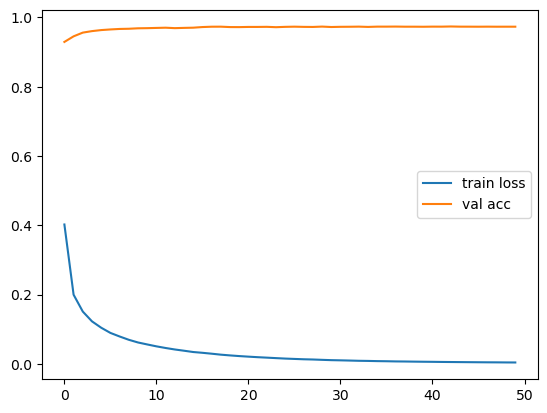

In [111]:
plt.plot(losses, label="train loss")
plt.plot(val_accs, label="val acc")
plt.legend()


# Fashion-MNIST

MNIST, while the classical small dataset, is too easy. Almost every model will get almost perfect accuracy. For a harder challenge with same characteristics we will use Fashion-MNIST, which has images of the same size and with the same number of classes, which are harder to classify, though.

In [103]:
!git clone https://github.com/zalandoresearch/fashion-mnist

4666.67s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
fatal: destination path 'fashion-mnist' already exists and is not an empty directory.


In [112]:
# import Fashion-MNIST
import sys
import os

# Add the path to the utils directory
fashion_mnist_path = os.path.join(os.getcwd(), 'fashion-mnist')
sys.path.append(fashion_mnist_path)

from utils import mnist_reader

X_train, y_train = mnist_reader.load_mnist(os.path.join(fashion_mnist_path, 'data/fashion'), kind='train')
X_test, y_test = mnist_reader.load_mnist(os.path.join(fashion_mnist_path, 'data/fashion'), kind='t10k')
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(60000, 784) (10000, 784) (60000,) (10000,)


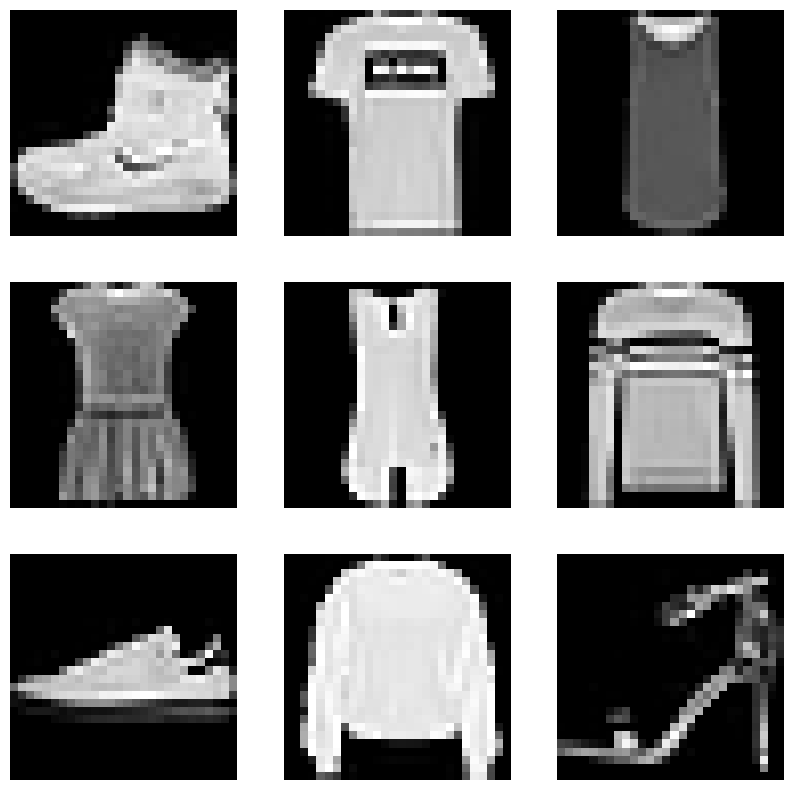

In [105]:
# Visualize the first 9 digites
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for i in range(9):
    ax = axs[i//3, i%3]
    ax.imshow(X_train[i].reshape(28, 28), cmap='gray')
    ax.axis('off')


In [113]:
# Normalize the input data:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('int64')
y_test = y_test.astype('int64')
X_train /= 255.0
X_test /= 255.0

In [114]:
model = MNIST_Net()

val_acc = validate(model, X_test, y_test)
print(f"Before training: validation accuracy: {val_acc}")

# Parameters
batch_size = 32
num_epochs = 50
lr = 0.1

# Training loop
losses = []
val_accs =[]
for epoch in range(num_epochs):
    # Shuffle the data at the beginning of each epoch
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)
    X_shuffled = X_train[indices]
    y_shuffled = y_train[indices]
    
    loss = 0.0
    
    for i in range(0, X_shuffled.shape[0], batch_size):
        X_batch = X_shuffled[i:i + batch_size]
        y_batch = y_shuffled[i:i + batch_size]
    
        # Forward pass
        preds = [model(x) for x in X_batch]
        
        # Loss calculation
        mb_loss = [ypred.cross_entropy(ytrue) for ytrue, ypred in zip(y_batch, preds)]
        mb_loss = sum(mb_loss) / len(mb_loss)
        loss += mb_loss.data * X_batch.shape[0] / X_shuffled.shape[0] 
        
        ### ZERO GRAD ###
        for p in model.parameters():
            p.grad = 0.0
            
        # backward pass
        mb_loss.backward()
    
        # update
        for p in model.parameters():
            # The weight update
            p.data += -lr * p.grad

    losses.append(loss)
    val_acc = validate(model, X_test, y_test)
    val_accs.append(val_acc)
    print(f"Epoch {epoch}, Loss: {loss}, validation accuracy: {val_acc}")

Before training: validation accuracy: 0.1071
Epoch 0, Loss: 0.569408546412093, validation accuracy: 0.8285
Epoch 1, Loss: 0.4097024665918298, validation accuracy: 0.8461
Epoch 2, Loss: 0.3756153061118856, validation accuracy: 0.8478
Epoch 3, Loss: 0.3517701459617214, validation accuracy: 0.863
Epoch 4, Loss: 0.33436591890910133, validation accuracy: 0.8637
Epoch 5, Loss: 0.3229231179392243, validation accuracy: 0.8703
Epoch 6, Loss: 0.310618770641207, validation accuracy: 0.8597
Epoch 7, Loss: 0.30230502154724914, validation accuracy: 0.8712
Epoch 8, Loss: 0.2931821182319657, validation accuracy: 0.8683
Epoch 9, Loss: 0.28480522698936656, validation accuracy: 0.8734
Epoch 10, Loss: 0.27964161657633335, validation accuracy: 0.8749
Epoch 11, Loss: 0.2732230117562066, validation accuracy: 0.874
Epoch 12, Loss: 0.26718258401464007, validation accuracy: 0.8646
Epoch 13, Loss: 0.2607668306662733, validation accuracy: 0.8762
Epoch 14, Loss: 0.25617616054000003, validation accuracy: 0.8789
Epo

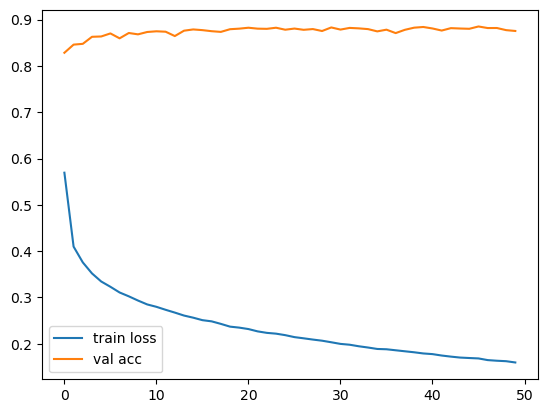

In [115]:
plt.plot(losses, label="train loss")
plt.plot(val_accs, label="val acc")
plt.legend()

## Stepsize tuning

A few words on finding good step size:
- Start big, find one (e.g. 1.0) for which the model diverges.
- Then halve it until the model converges.

Alternatively:
- Find lower bound on good stepsize (nothing moves)
- Find upper bound on stepsize (loss unstable, explodes)
- Search linearly between them
- Search exponentially between them.